# Imports

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
from collections import defaultdict
import pickle
import pandas as pd
import numpy as np
import scipy as sp

from epiml.loadepiml import LoadEpiml, save_search, load_search
from epiml.epimlsklearn.epimlmetrics import pu_scorer, prior_squared_error_scorer_015, brier_score_labeled_loss_scorer, \
    f1_assumed_scorer, f1_labeled_scorer, report_metrics, f1_assumed_beta10_scorer, pu_mix_assumed_f1beta10_scorer
from epiml.semisuperhelper import SemiSupervisedHelper
from epiml.epimlsklearn.pnuwrapper import PNUWrapper
from epiml.epimlsklearn.jsearchcv import JRandomSearchCV, extract_score_grid
from epiml.epimlsklearn.nestedcross import NestedCV
from epiml.epimlsklearn.frankenscorer import FrankenScorer, extract_scores_from_nested
from epiml.epimlsklearn.repeatedsampling import RepeatedRandomSubSampler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.externals.joblib import Parallel, delayed

from lime.lime_tabular import LimeTabularExplainer

In [3]:
from epiml.modeldeepdive import ModelDeepDive, create_model_6

# Load and then Train Model 6

In [5]:
path = "C:\\Data\\010317\\membership14_final_0103.txt"
print("Loading {}".format(path))
try:
    lc = LoadEpiml(path)
except FileNotFoundError:
    #This is for running on a machine not on network that can see the data
    print("File doesn't exist, generating fake data!")
    from sklearn.datasets import make_classification
    X, y = make_classification(n_samples=10000, n_features=200, n_informative=50, n_redundant=100, n_classes=2,
                               n_clusters_per_class=3, weights=[0.9], flip_y=0, hypercube=False,
                               random_state=101)

    #make this like the unlabeled problem we are solving -change most to unlabeled class == -1
    rnd_unlabeled = np.random.choice([True, False], size=len(y), replace=True, p=[0.8,0.2])
    y[rnd_unlabeled] = -1
    X = pd.DataFrame(X)
    y = pd.Series(y)
else:
    X = lc.X
    y = lc.y
print("Done loading")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=771, stratify=y)
print("Split Data: train_size {}, test_size {}".format(X_train.shape, X_test.shape))

Loading C:\Data\010317\membership14_final_0103.txt
Done loading
Split Data: train_size (352556, 287), test_size (88140, 287)


In [6]:
print("Create and train model")
model6 = create_model_6(X_train, y_train)
print("Done with model {}".format(model6))
scores, _ = FrankenScorer()(model6, X_test.values, y_test.values)
explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values,
                                 feature_selection='lasso_path', class_names=['No EPI','EPI'],
                                 discretize_continuous=True)

Create and train model
Done with model PNUWrapper(base_estimator=RepeatedRandomSubSampler(base_estimator=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=47, max_features=49, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=6,
            min_samples_split=0.02, min_weight...     random_state=83, sample_imbalance=0.34927465901033783,
             verbose=0, voting='thresh'),
      num_unlabeled=1.0, pu_learning=True, random_state=1,
      threshold_set_pct=None)


C:\Users\jeffrey.gomberg\AppData\Local\Continuum\Anaconda3\envs\creon\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [6]:
scores

{'SCORE': 0.85387547649301154,
 'assumed_brier': 0.047231727428331254,
 'assumed_brier_neg': 0.046789270426547652,
 'assumed_f1': 0.11502909962341663,
 'assumed_f1beta10': 0.71861765204133488,
 'confusion_matrix_lab': array([[182,  33],
        [ 82, 336]]),
 'confusion_matrix_un': array([[82634,  5088],
        [   82,   336]]),
 'labeled_acc': 0.81832543443917849,
 'labeled_avg_prec': 0.92196936051312495,
 'labeled_brier': 0.13823838650617615,
 'labeled_brier_neg': 0.13464569061816015,
 'labeled_brier_pos': 0.14008630424761978,
 'labeled_f1': 0.85387547649301154,
 'labeled_prec': 0.91056910569105687,
 'labeled_recall': 0.80382775119617222,
 'labeled_roc_auc': 0.82516968955157444,
 'pr_one_unlabeled': 0.057766807226850424,
 'pu_mix_assumed_f1beta10': 82.361524825021291,
 'pu_score': 10.499759620887799}

# Create ModelDeepDive with Model 6

In [7]:
deep = ModelDeepDive(model6, explainer, X_test, y_test)

### Explore Model 6 using ModelDeepDive functions

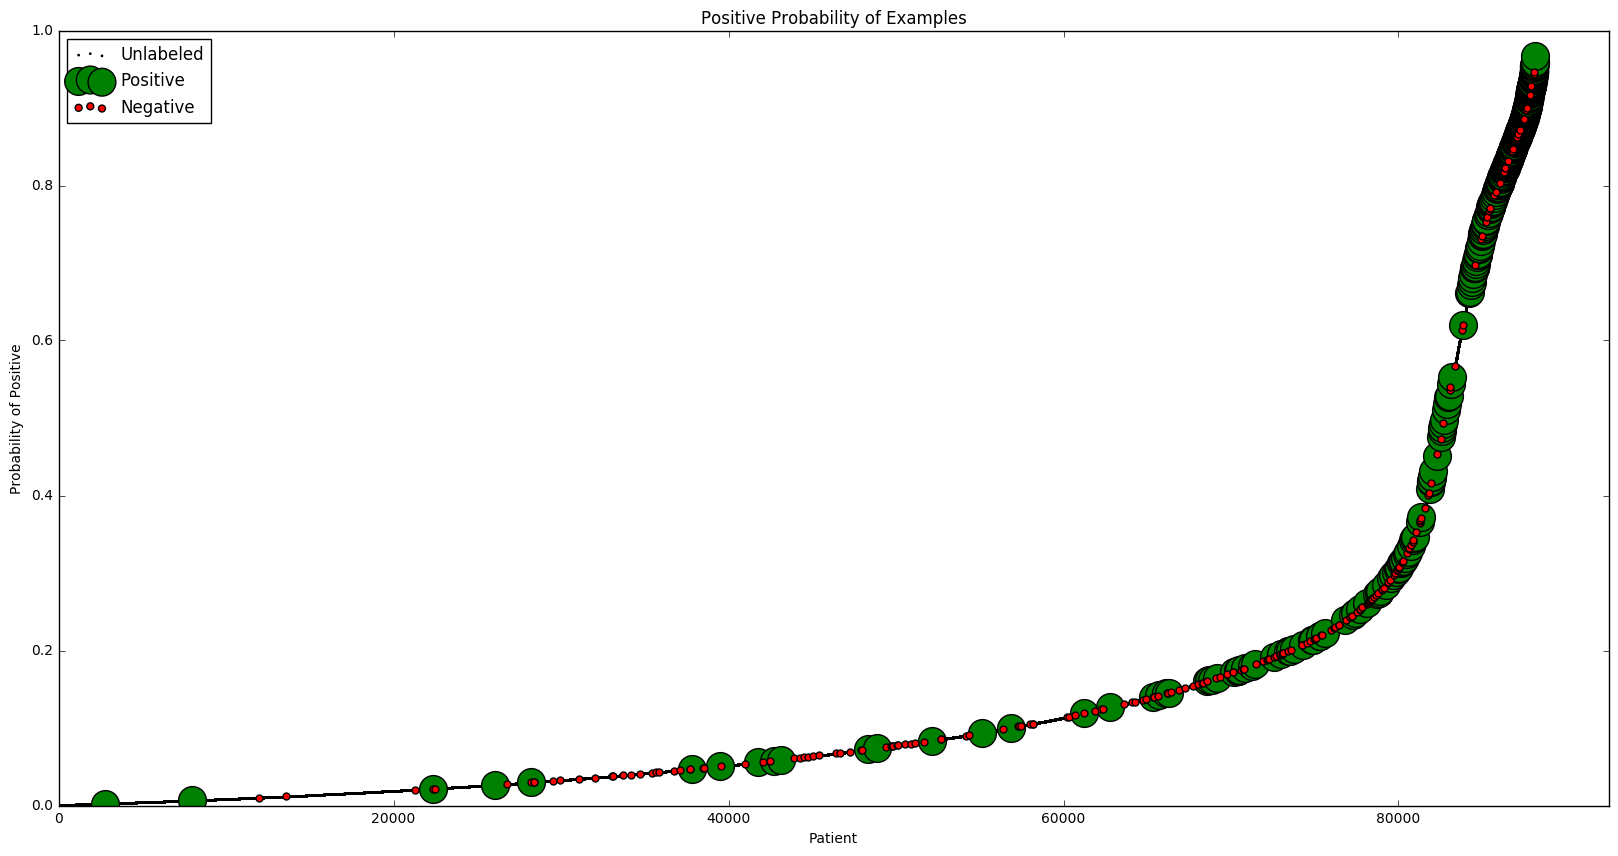

In [8]:
deep.generate_probability_plot()

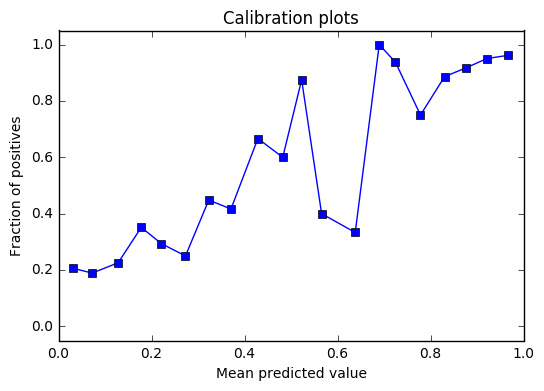

In [9]:
deep.generate_calibration_plot()

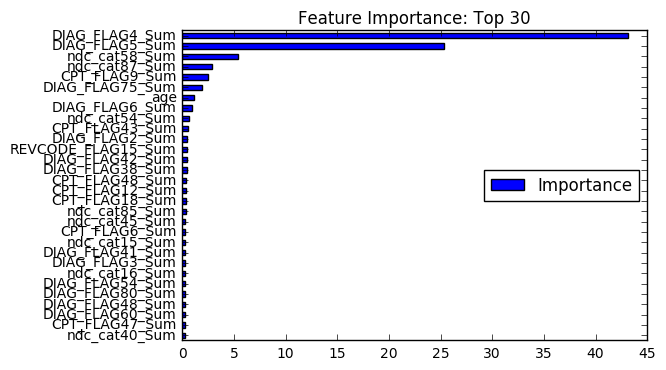

In [10]:
deep.generate_feature_importance_plot(num_features=30)

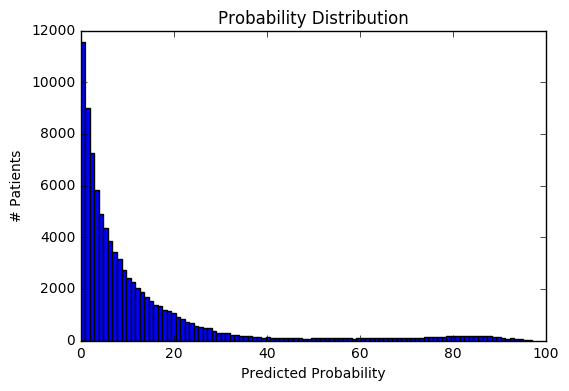

In [11]:
deep.generate_probability_distribution()

In [12]:
deep.generate_percentile_table()

Unlabeled  Negative  Positive  # Patients  % unlabeled  \
Percentile Bucket                                                           
0%-5%                39163.0      27.0       6.0       39196     0.999158   
5%-10%               17577.0      30.0       8.0       17615     0.997843   
10%-15%              10155.0      25.0       7.0       10187     0.996859   
15%-20%               6471.0      28.0      15.0        6514     0.993399   
20%-25%               4000.0      22.0      10.0        4032     0.992063   
25%-30%               2212.0      23.0       8.0        2243     0.986179   
30%-35%               1198.0      15.0      14.0        1227     0.976365   
35%-40%                726.0       6.0       2.0         734     0.989101   
40%-45%                510.0       3.0       6.0         519     0.982659   
45%-50%                440.0       3.0       6.0         449     0.979955   
50%-55%                461.0       2.0       5.0         468     0.985043   
55%-60%                468.0       1.0       1.0         470     0.995745   
60%-65%                473.0       2.0       1.0         476     0.993697   
65%-70%                470.0       1.0      12.0         483     0.973085   
70%-75%                542.0       2.0      17.0         561     0.966132   
75%-80%                762.0       7.0      24.0         793     0.960908   
80%-85%                832.0       6.0      71.0         909     0.915292   
85%-90%                697.0       8.0     105.0         810     0.860494   
90%-95%                320.0       4.0      91.0         415     0.771084   
95%-100%                30.0       0.0       9.0          39     0.769231   

                   % Positive of Labeled  % Negative of Labeled  
Percentile Bucket                                                
0%-5%                           0.181818               0.818182  
5%-10%                          0.210526               0.789474  
10%-15%                         0.218750               0.781250  
15%-20%                         0.348837               0.651163  
20%-25%                         0.312500               0.687500  
25%-30%                         0.258065               0.741935  
30%-35%                         0.482759               0.517241  
35%-40%                         0.250000               0.750000  
40%-45%                         0.666667               0.333333  
45%-50%                         0.666667               0.333333  
50%-55%                         0.714286               0.285714  
55%-60%                         0.500000               0.500000  
60%-65%                         0.333333               0.666667  
65%-70%                         0.923077               0.076923  
70%-75%                         0.894737               0.105263  
75%-80%                         0.774194               0.225806  
80%-85%                         0.922078               0.077922  
85%-90%                         0.929204               0.070796  
90%-95%                         0.957895               0.042105  
95%-100%                        1.000000               0.000000